In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)
#Users = Base.classes.users


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
import sqlite3
conn = sqlite3.connect('Resources/hawaii.sqlite')
cur = conn.cursor()
cur.execute('''
CREATE TABLE IF NOT EXISTS measurement (
    station VARCHAR(50) PRIMARY KEY,
    date DATE,
    prcp INT,
    tobs INT
);
''')

cur.execute('''
CREATE TABLE IF NOT EXISTS station (
    station VARCHAR(50) PRIMARY KEY,
    name VARCHAR(50),
    latitude FLOAT,
    longitude FLOAT,
    elevation FLOAT
);
''')



In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)


# Exploratory Precipitation Analysis

In [9]:
most_recent_date = session.query(func.max(Base.classes.measurement.date)).scalar()
most_recent_date

'2017-08-23'

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Base.classes.measurement.date)).scalar()
most_recent_date

'2017-08-23'

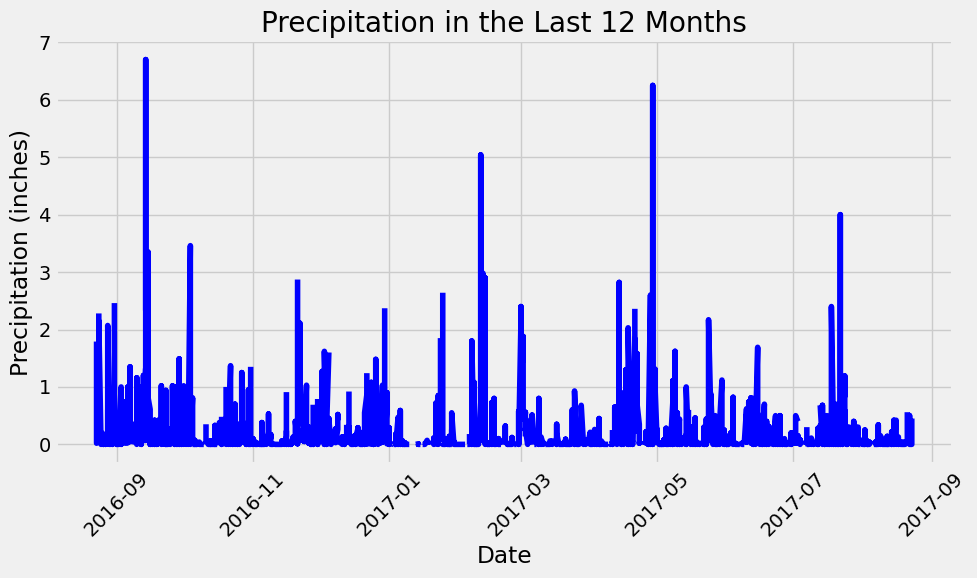

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_dt = pd.to_datetime(most_recent_date)

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date_dt - pd.DateOffset(years=1)

# Convert the 'one_year_ago' date to a string in 'YYYY-MM-DD' format
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform the query using the date string
precip_data = session.query(Base.classes.measurement.date, Base.classes.measurement.prcp)\
    .filter(Base.classes.measurement.date >= one_year_ago_str).all()

# Save the query results as a Pandas DataFrame
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

# Convert the 'date' column to datetime format
precip_df['date'] = pd.to_datetime(precip_df['date'])

# Sort the dataframe by date
precip_df = precip_df.sort_values('date')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(precip_df['date'], precip_df['precipitation'], label='Precipitation', color='b')
plt.title("Precipitation in the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precip_df['precipitation'].describe()
print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Base.classes.station.station)).scalar()
total_stations

9

In [15]:
active_stations = session.query(
    Base.classes.measurement.station, 
    func.count(Base.classes.measurement.station).label('station_count')
).group_by(Base.classes.measurement.station)\
 .order_by(func.count(Base.classes.measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    Base.classes.measurement.station, 
    func.count(Base.classes.measurement.station).label('station_count')
).group_by(Base.classes.measurement.station)\
 .order_by(func.count(Base.classes.measurement.station).desc()).all()


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]  # The station ID of the most active station

# Step 2: Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Base.classes.measurement.tobs),  # Lowest temperature
    func.max(Base.classes.measurement.tobs),  # Highest temperature
    func.avg(Base.classes.measurement.tobs)   # Average temperature
).filter(Base.classes.measurement.station == most_active_station).all()

# Step 3: Output the temperature statistics
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(lowest_temp,highest_temp,avg_temp)

54.0 85.0 71.66378066378067


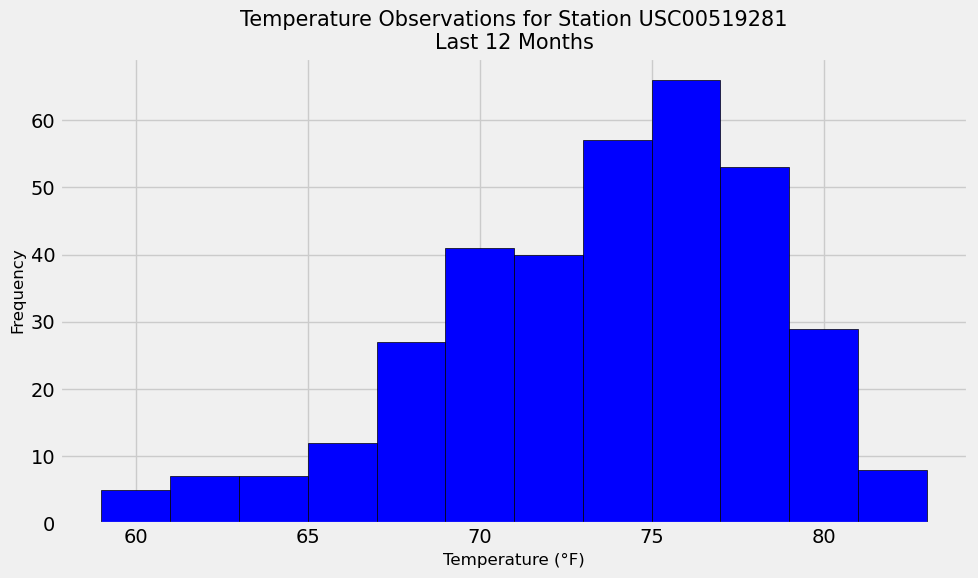

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Base.classes.measurement.tobs)\
    .filter(Base.classes.measurement.station == most_active_station)\
    .filter(Base.classes.measurement.date >= one_year_ago_str).all()


temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Step 6: Plot the data as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['tobs'], bins=12, color='blue', edgecolor='black')

# Customize the plot
plt.title(f"Temperature Observations for Station {most_active_station}\nLast 12 Months", fontsize=15)
plt.xlabel("Temperature (°F)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


# Close Session

In [19]:
# Close Session
session.close()